In [1]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.feature_selection import SelectFromModel

from utils.data_prep import *
from utils.visuals import *
from utils.test_menager import *
from utils.col_transformers import *

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
filterwarnings("ignore")

In [2]:
file_path = os.path.join("data", "Train_nyOWmfK.csv")
data = pd.read_csv(file_path, encoding="ISO-8859–1")

In [3]:
data.head(3)

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,HDFC Bank,N,0,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),ICICI Bank,Y,13,HBXA,200000.0,2.0,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,State Bank of India,Y,0,HBXX,450000.0,4.0,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0


# Happy Customer Bank Dataset

## Data exploration

The data was collected over a three-month period in 2015.

The dataset includes **26 columns** and **87 020 entries**.


It consists of:

* 13 numerical features:
    * 11 continous (Monthly_Income, Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI, Loan_Amount_Submitted, Loan_Tenure_Submitted,
      Interest_Rate, Processing_Fee, EMI_Loan_Submitted, Var4, Var5)
    * 2 binary (LoggedIn, **Disbursed - target variable**)
* 13 object-type features:
    * 2 with dates (DOB, Lead_Creation_Date)
    * 7 categorical with multiple levels (ID, City, Employer_Name, Salary_Account, Var1, Var2, Source)
    * 4 binary categorical (Gender, Mobile_Verified, Filled_Form, Device_Type)
 
The ID column contains unique values for each sample and cannot be used for prediction. The LoggedIn column is for problem understanding purposes and cannot be used for prediction.

The meaning of Var1, Var2, Var4, Var5 and Source is unknown.

### Missing values

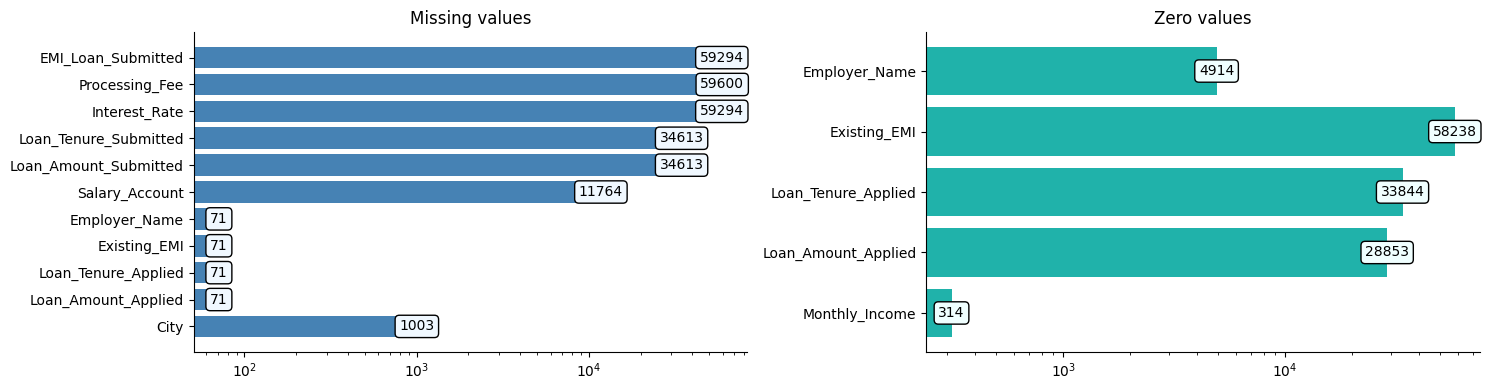

In [55]:
missings_plot(data)

#### There are many NaN and zero values in the dataset. The following assumptions were made:

* At least the majority of these values are not random.

* We have corresponding NaN values in columns sets:
  * 71 values in **Loan_Amount_Applied**, **Loan_Tenure_Applied**, **Existing_Emi**, **Employer_Name**:
    * These missing values may represent individuals who clicked on the bank's advertisement but did not take any further action or simply did not provide this information. Alternatively, they could be the same as the numerous zero values in these columns, where clients chose not to share this information.
    * Zeros might indicate a preliminary check to see if any loan can be processed.
    * Zeroes in the Existing_EMI column might, of course, indicate a lack of any outstanding debts 
  * 34,613 NaN values in **Loan_Amount_Submitted** and **Loan_Tenure_Submitted**:
    * These missing values may indicate individuals who applied for a loan but did not receive an offer from the bank, or in some cases, the application was initially accepted without any modificatio s.
  * 59,294 values in **Interest_Rate**, **Processing_Fee**, **EMI_Loan_Submitted**:
    * In addition to the aforementioned situations, the remaining 24,681 missing values.
    * These missing values can represent individuals who either completely accepted or completely rejected the initial terms.
    * On the other hand, the non-missing observations in these columns may represent individuals who negotiated loan terms and obtained additional, non-default offer parameters.

* The missing values in **City** column may indicate a lack of a permanent place of residence, but also carelessness in form completion.

* The missing values in **Salary_Account** column may indicate the absence of a bank account, but they could also result from carelessness during application filling or reluctance to share this information; notably, there aren't many positive loan disbursements for samples where the bank account information was not provided.

* Firstly, algorithms capable of handling missing values will be tested, and in subsequent steps, various methods of imputing them will be examined.
them will be examined.
d.

### Categorical variables

In [56]:
data.describe(include=['O'])

,ID,Gender,City,DOB,Lead_Creation_Date,Employer_Name,Salary_Account,Mobile_Verified,Var1,Filled_Form,Device_Type,Var2,Source
count,87020,87020,86017,87020,87020,86949,75256,87020,87020,87020,87020,87020,87020
unique,87020,2,697,11345,92,43567,57,2,19,2,2,7,30
top,ID000002C20,Male,Delhi,11-Nov-80,03-Jul-15,0,HDFC Bank,Y,HBXX,N,Web-browser,B,S122
freq,1,49848,12527,306,2315,4914,17695,56481,59294,67530,64316,37280,38567


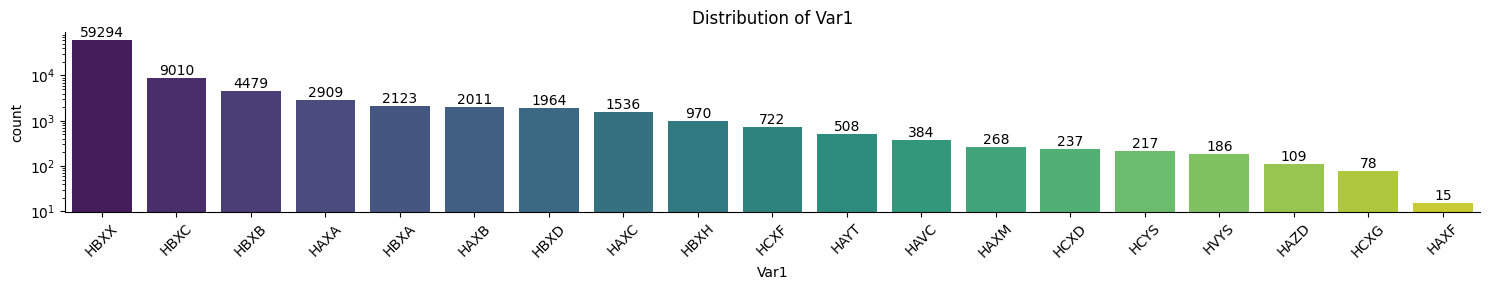

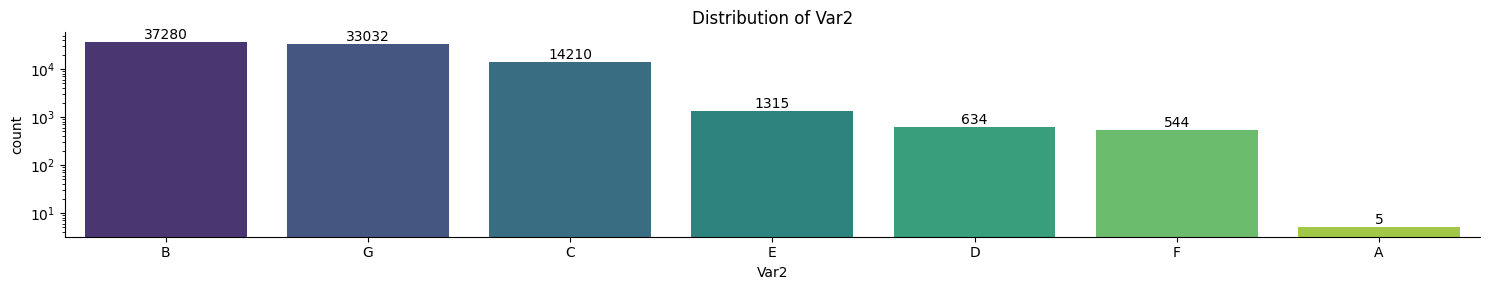

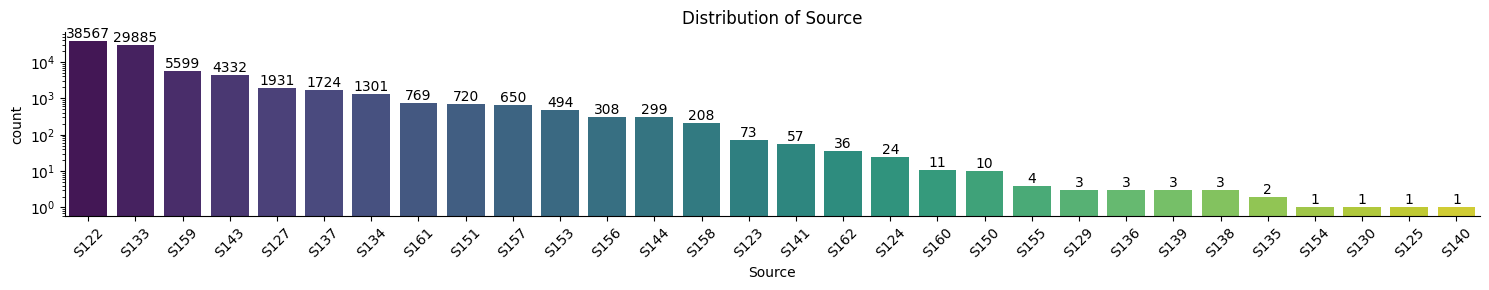

In [5]:
countplot("Var1", "Var2", "Source", data = data)

### Numerical variables

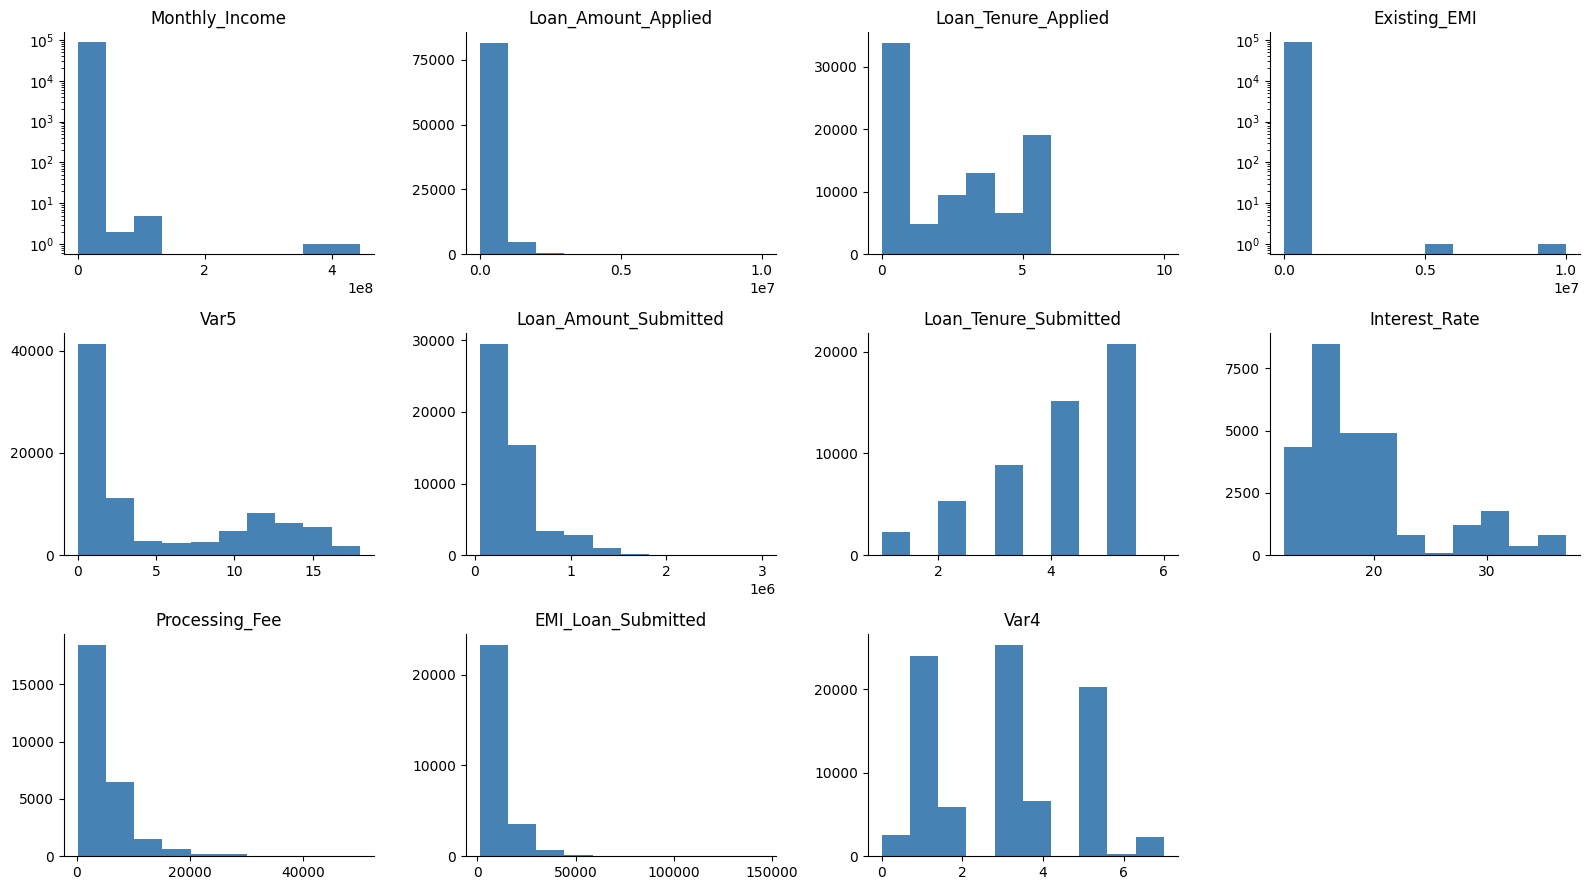

In [6]:
features_to_create_hist = [feature for feature in data.select_dtypes([int, float]).columns 
                           if data[feature].nunique() > 2]

grid_of_hists(3, 4, features_to_create_hist, data)

As seen above, the numerical features display different distributions and varying value ranges. It will be explored the option of applying transformations to bring these values closer to a normal distribution or scale them, especially when using methods that require such transformations. However, these transformations are not necessary when using tree-based algorithms.

Additionally, certain variables (below) look more like categorical features. It will be considered converting them into categorical variables, simultaneously grouping rarely occurring categories. For the initial trials, however, they will remain unchanged.

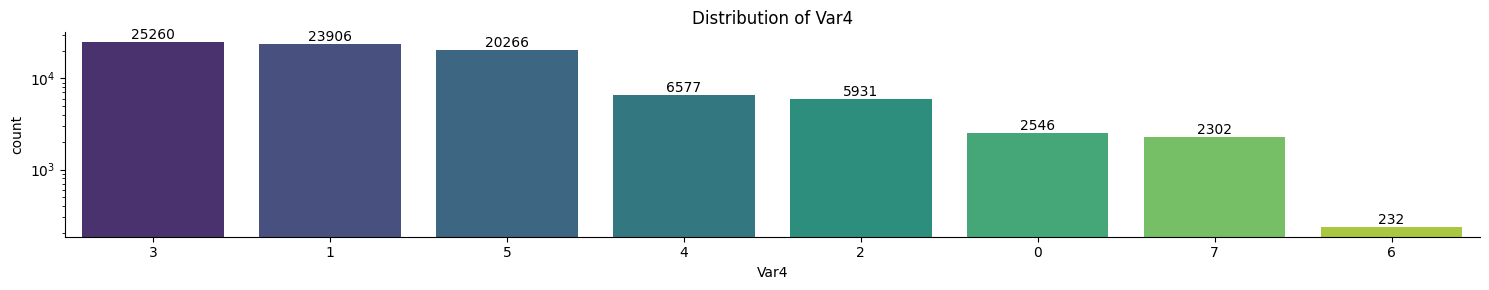

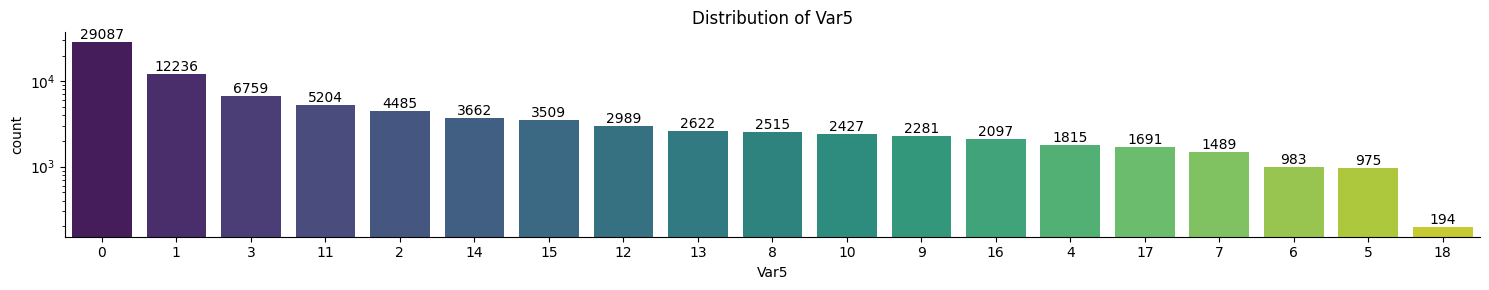

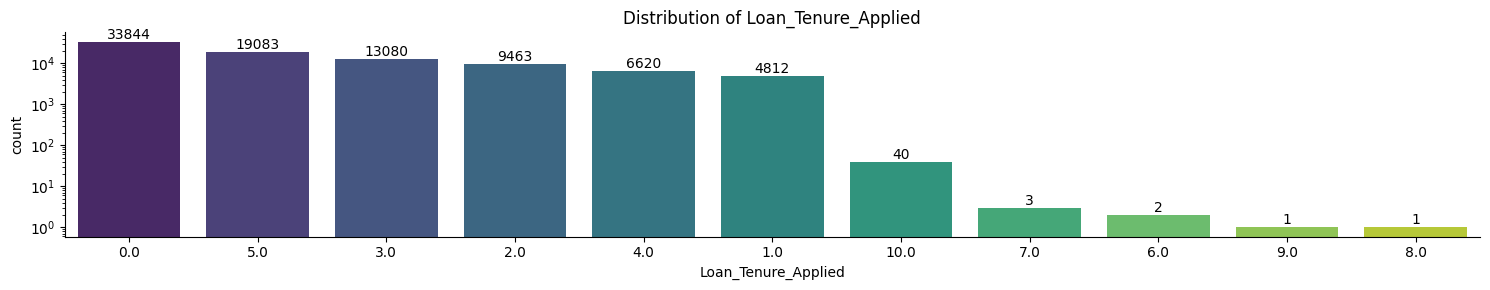

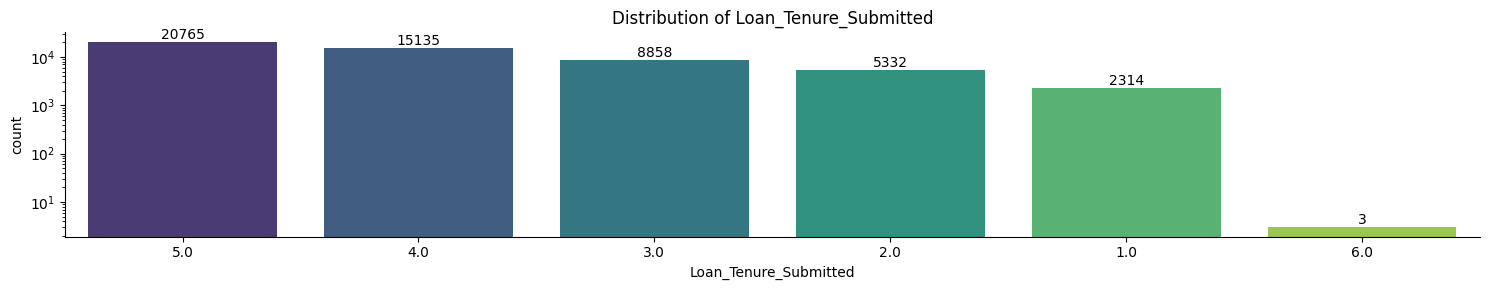

In [7]:
countplot("Var4", "Var5", "Loan_Tenure_Applied", "Loan_Tenure_Submitted", data = data)

### Target variable

In [163]:
data.Disbursed.value_counts(normalize=True).round(4)

Disbursed
0    0.9854
1    0.0146
Name: proportion, dtype: float64

In this dataset, highly imbalanced classes are present. 
The following strategies were adopted to address this issue:

* stratified train_test_split
* stratified KFold for cross-validation
* class weighting increased for class 1 (for models that support this option))."

# Experiments

## First data version **data_v1**

* **ID** column removed.

* **City** column cransformation: from 698 to 2 categories: Y/N ([cities with over 1 million residents and smaller](https://www.loomsolar.com/blogs/collections/list-of-cities-in-india)), missing values left unchanged. Renamed to **Is_Big_City**. 

* **Employer_Name** column cransformation: from 43,568 to binary: 1 (provided) / 0 (not-provided - missing values, zeros and different numeric values). Renamed to **Employer_Provided**. The column also contained incorrect values - 50 different numerical values (for example, 54543543535, 2233, 12), which were also converted to 0, and an unknown number of incorrect names (such as "JSJSJSH," "ABC"), which are too difficult to distinguish from valid names.

* **Salary_Account** column cransformation: from 58 to binary: 1 (provided) / 0 (not-provided - missing values). Renamed to **Account_Provided**.

* **DOB** column cransformation: from date of birth to year of birth, which is analogous to using age, as the data was collected in the same year. Renamed to **Year_Of_Birth**.

* **Lead_Creation_Date** column cransformation: from date of creation to day of the year. Renamed to **Lead_Creation_Day**.

* **Var1, Var2, Source** - rare values aggregated as "Others".

* Numerical variables and missing values left unchanged, except filling 71 corresposponding NaNs in **Loan_Amount_Applied, Loan_Tenure_Applied, Existing_EMI** with 0.

In [4]:
data_v1 = data_preparing_v1(data)

In [5]:
X = data_v1.drop(["LoggedIn", "Disbursed"], axis = 1)
y = data_v1.Disbursed

X.shape, y.shape

((87020, 23), (87020,))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [7]:
X_train.head(3)

,Gender,Is_Big_City,Monthly_Income,Year_Of_Birth,Lead_Creation_Day,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Provided,Account_Provided,Mobile_Verified,Var5,Var1,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
26733,Female,Y,50000,76,151,1000000.0,5.0,0.0,1,1,N,15,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,3
81500,Female,Y,17475,88,208,200000.0,3.0,4732.0,1,1,N,1,HBXX,NaN,NaN,NaN,NaN,NaN,N,Web-browser,G,S122,3
81659,Female,N,52000,62,208,0.0,0.0,0.0,1,1,Y,13,HBXX,1050000.0,5.0,NaN,NaN,NaN,N,Mobile,G,S122,3


Tree-based algorithms were applied:

* AdaBoostClassifier,
* BaggingClassifier,
* DecisionTreeClassifier,
* HistGradientBoostingClassifier,
* RandomForestClassifier,
 
in their default or slightly modified parameter configurations.

The tests were conducted using **stratified, shuffled 5-split cross-validation on the training set** (random_state = 42).

In [7]:
models = [DecisionTreeClassifier(min_samples_leaf = 50, random_state = 42), 
          DecisionTreeClassifier(class_weight = {1:50}, min_samples_leaf = 100, max_depth = 6, random_state = 42),
          BaggingClassifier(n_estimators = 100, random_state = 42, n_jobs = -1),
          BaggingClassifier(n_estimators = 200, max_features = 0.5, random_state = 42, n_jobs = -1),
          HistGradientBoostingClassifier(random_state = 42),
          HistGradientBoostingClassifier(class_weight = {1:50}, random_state = 42),
          AdaBoostClassifier(random_state = 42),
          AdaBoostClassifier(n_estimators = 100, random_state = 42),
          RandomForestClassifier(min_samples_leaf = 10, random_state = 42, n_jobs = -1),
          RandomForestClassifier(class_weight = {1:50}, min_samples_leaf = 20, random_state = 42, n_jobs = -1)]

### Missing values imputation tests

In this section, tests were conducted with various methods of handling missing values. The following were tested:

* imputation with an out-of-range value (-1) by **Simple Imputer**,
* **KNN Imputer** (preceded by scaling for better performance),
* experimental **Iterative Imputer** (preceded by power transformation for better performance),
* **the lack of imputation** was checked for models that support it.

**One-hot encoding** was applied to categorical features.

In [9]:
num_preprocessors = [
    
            ("SimpleImputer",
             SimpleImputer(strategy = "constant", 
                           fill_value = -1, 
                           add_indicator = True)),
    
            ("KNNImputer",
             make_pipeline(
                MinMaxScaler(),
                KNNImputer(add_indicator = True))),
    
            ("IterativeImputer",
             make_pipeline(
                PowerTransformer(),
                IterativeImputer(sample_posterior = True,
                                 add_indicator = True, 
                                 random_state = 42)))
]

results1 = collect_tests_results(models,
                                  X_train, y_train,
                                  test = "imputation",
                                  preprocessors = None)

results2 = collect_tests_results(models,
                                  X_train, y_train,
                                  test = "imputation",
                                  preprocessors = num_preprocessors)

results = create_results_dataframe(results1, results2)
results.to_csv("data/data_v1_results_imputation.csv")

In [20]:
results = pd.read_csv("data/data_v1_results_imputation.csv")
results.set_index("Model", inplace = True)

In [21]:
results.sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Imputation,Time[s]
Model,,,,
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8446,none,1.38
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8425,SimpleImputer,1.54
HistGradientBoostingClassifier,"class_weight: None, min_samples_leaf: 20",0.8424,SimpleImputer,1.30
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8422,SimpleImputer,1.73
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8422,IterativeImputer,3.30


In [11]:
results.groupby("Model").describe(percentiles=[])

ROC_AUC                                       \
                                 count      mean       std     min      50%   
Model                                                                         
AdaBoostClassifier                 6.0  0.831217  0.002865  0.8265  0.83225   
BaggingClassifier                  8.0  0.795287  0.020848  0.7673  0.79890   
DecisionTreeClassifier             8.0  0.751413  0.055428  0.6787  0.77040   
HistGradientBoostingClassifier     8.0  0.841800  0.001517  0.8394  0.84170   
RandomForestClassifier             6.0  0.836217  0.005934  0.8280  0.83730   

                                       Time[s]                               \
                                   max   count       mean         std   min   
Model                                                                         
AdaBoostClassifier              0.8339     6.0  79.005000  108.819959  4.73   
BaggingClassifier               0.8215     8.0  63.043750   95.808439  6.65   
DecisionTreeClassifier          0.8072     8.0  53.486250   97.013569  0.38   
HistGradientBoostingClassifier  0.8446     8.0  54.208750   96.697790  1.29   
RandomForestClassifier          0.8422     6.0  72.811667  107.742204  1.73   

                                                
                                   50%     max  
Model                                           
AdaBoostClassifier              11.250  221.90  
BaggingClassifier               13.540  221.63  
DecisionTreeClassifier           1.490  211.14  
HistGradientBoostingClassifier   2.330  211.70  
RandomForestClassifier           4.535  213.08

In [12]:
results.groupby("Imputation").describe(percentiles=[])

ROC_AUC                                             Time[s]  \
                   count     mean       std     min      50%     max   count   
Imputation                                                                     
IterativeImputer    10.0  0.80713  0.050088  0.6787  0.82785  0.8422    10.0   
KNNImputer          10.0  0.80558  0.049656  0.6827  0.82970  0.8410    10.0   
SimpleImputer       10.0  0.81165  0.044902  0.7001  0.83355  0.8425    10.0   
none                 6.0  0.81150  0.033624  0.7629  0.82125  0.8446     6.0   

                                                              
                     mean       std     min      50%     max  
Imputation                                                    
IterativeImputer    7.531  5.931199    2.34    4.535   17.27  
KNNImputer        214.195  4.530730  210.04  212.390  221.90  
SimpleImputer       4.176  4.046329    0.38    2.005   11.07  
none                2.965  3.265901    0.38    1.335    7.61

### Category encoders tests

In this section, tests were conducted with various methods of encoding categorical features. The following were tested:

* **One-Hot Encoder**,
* **Ordinal Encoder**,
* **Target Encoder**,
* **Multi-Task Encoder** (custom encoder, encoding features based on their frequency of occurrence).

Missing values in numerical columns were filled with the vallue -1 using Simple Imputer.
For the categorical column Is_Big_City, categorical encoders will encode the missing values as a separate category.

In [9]:
cat_preprocessors = [
    OneHotEncoder(),
    OrdinalEncoder(encoded_missing_value = -1),
    TargetEncoder(random_state=42),
    MultiTaskEncoder()
]

In [10]:
results = collect_tests_results(models, 
                                X_train, y_train, 
                                test = "encoders", 
                                preprocessors = cat_preprocessors)

results = create_results_dataframe(results)
results.to_csv("data/data_v1_results_cat_encoding.csv")

In [17]:
results = pd.read_csv("data/data_v1_results_cat_encoding.csv")
results.set_index("Model", inplace = True)

In [19]:
results.sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Encoder,Time[s]
Model,,,,
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8437,TargetEncoder,2.04
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8434,MultiTaskEncoder,1.13
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8425,OneHotEncoder,1.50
HistGradientBoostingClassifier,"class_weight: None, min_samples_leaf: 20",0.8424,OneHotEncoder,1.25
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8422,OneHotEncoder,2.12


In [12]:
results.groupby("Encoder").describe(percentiles=[])

ROC_AUC                                             Time[s]  \
                   count     mean       std     min      50%     max   count   
Encoder                                                                        
MultiTaskEncoder    10.0  0.80932  0.047348  0.6882  0.83005  0.8434    10.0   
OneHotEncoder       10.0  0.81165  0.044902  0.7001  0.83355  0.8425    10.0   
OrdinalEncoder      10.0  0.80817  0.048079  0.6842  0.83020  0.8402    10.0   
TargetEncoder       10.0  0.80903  0.050156  0.6789  0.83200  0.8437    10.0   

                                                       
                   mean       std   min    50%    max  
Encoder                                                
MultiTaskEncoder  2.678  2.353177  0.43  1.835   6.62  
OneHotEncoder     4.172  3.983842  0.45  2.180  10.38  
OrdinalEncoder    2.757  2.503842  0.31  1.935   7.12  
TargetEncoder     3.184  2.993560  0.38  2.105   8.43

### Feature selection tests

Missing values in numerical columns were filled with the vallue -1 using Simple Imputer.
For the categorical columns, Target Encoder was applied.

**Random Forest Classifier** was used as the feature selection estimator.

In [8]:
results = collect_tests_results(models,
                                X_train, y_train,
                                test = "feature_selection")

In [9]:
results = create_results_dataframe(results)
results.to_csv("data/data_v1_results_feature_selection.csv")

In [ ]:
results = pd.read_csv("data/data_v1_results_feature_selection.csv")
results.set_index("Model", inplace = True)

In [16]:
results.sort_values(by = ["ROC_AUC"], ascending = False).head()

,Parameters,ROC_AUC,Threshold,Selected_features,Time[s]
Model,,,,,
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8437,0.001,1.000,3.80
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8432,0.002,0.893,3.75
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8421,0.010,0.786,3.68
RandomForestClassifier,"class_weight: {1: 50}, min_samples_leaf: 20, n_estimators: 100",0.8419,0.005,0.857,3.58
HistGradientBoostingClassifier,"class_weight: {1: 50}, min_samples_leaf: 20",0.8411,0.002,0.893,2.85


In [15]:
results.groupby("Selected_features").describe(percentiles=[]).sort_values(by = "Selected_features", ascending = False)

ROC_AUC                                              \
                    count     mean       std     min      50%     max   
Selected_features                                                       
1.000                10.0  0.80903  0.050156  0.6789  0.83200  0.8437   
0.893                10.0  0.80908  0.050333  0.6776  0.83120  0.8432   
0.857                10.0  0.80944  0.049873  0.6789  0.83210  0.8419   
0.786                10.0  0.80907  0.050014  0.6786  0.83190  0.8421   
0.750                10.0  0.80545  0.050235  0.6776  0.82845  0.8398   
0.536                10.0  0.80766  0.047447  0.6892  0.83000  0.8406   
0.357                10.0  0.80397  0.045567  0.6890  0.82695  0.8335   
0.286                10.0  0.80165  0.044842  0.6897  0.82505  0.8294   

                  Threshold                                           Time[s]  \
                      count   mean           std    min    50%    max   count   
Selected_features                                                               
1.000                  10.0  0.001  2.285699e-19  0.001  0.001  0.001    10.0   
0.893                  10.0  0.002  4.571398e-19  0.002  0.002  0.002    10.0   
0.857                  10.0  0.005  9.142795e-19  0.005  0.005  0.005    10.0   
0.786                  10.0  0.010  1.828559e-18  0.010  0.010  0.010    10.0   
0.750                  10.0  0.015  3.657118e-18  0.015  0.015  0.015    10.0   
0.536                  10.0  0.020  3.657118e-18  0.020  0.020  0.020    10.0   
0.357                  10.0  0.030  7.314236e-18  0.030  0.030  0.030    10.0   
0.286                  10.0  0.040  7.314236e-18  0.040  0.040  0.040    10.0   

                                                       
                    mean       std   min    50%   max  
Selected_features                                      
1.000              4.849  2.791879  2.29  3.850  9.64  
0.893              4.674  2.608104  2.21  3.805  9.07  
0.857              4.658  2.599751  2.28  3.695  9.04  
0.786              4.577  2.456981  2.30  3.745  8.70  
0.750              4.512  2.332613  2.35  3.800  8.38  
0.536              4.114  1.975293  2.21  3.710  7.53  
0.357              3.730  1.453440  2.22  3.545  6.49  
0.286              3.580  1.368056  2.25  3.345  6.28

The best results were achieved by retaining 100% of the features.

## Different data versions tests